<a href="https://colab.research.google.com/github/ciencia-datos-unison/taller-cnn/blob/master/cnn_ejemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/rn-unison/rn-jupyter/master/cnn-sencilla/imagenes/rn3.png" width="200">

<img src="http://www.identidadbuho.uson.mx/assets/letragrama-rgb-150.jpg" width="200">

# Una red neuronal convolucional simple 


[**Julio Waissman Vilanova**](http://mat.uson.mx/~juliowaissman/), 11 de junio de 2019.



En esta libreta se muestra el ejemplo básico para una red convolucional
aplicada al conjunto de datos [MNIST](http://yann.lecun.com/exdb/mnist/).
La estructura de la red que vamos a hacer está inspirada (y es básicamente la misma) que la arquitectura conocisa como [LeNet 5](https://engmrk.com/lenet-5-a-classic-cnn-architecture/), la cual fue una de las primeras redes neuronales convolucionales exitosas.

In [0]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image  # Esto es para desplegar imágenes en la libreta

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('ggplot')

## 1. Cargar datos

Primero cargamos los archivos que se utilizan para el aprendizaje. En este caso son datos que provienen de los mismos ejemplos de TensorFlow. 

Para otro tipo de problemas, es necesario hacer un proceso conocido como *Data Wrangling*, que normalmente se realiza con la ayuda de *Pandas*. 

In [21]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Para que un aprendizaje tenga sentido es necesario tener bien separado un conjunto de datos de aprendizaje y otro de prueba (en caso de grandes conjuntos de datos es la opción). Como vemos tanto las imágenes como las etiquetas están separados en archivos de datos y de aprendizaje.



El objeto `mnist` es un objeto tensorflow que contiene 3 objetos tipo tensorflow: *test*, *train* y *validation*, los cuales a su vez contienen *ndarrays* de *numpy*. La estructura es la misma para cada conjunto de datos. Veamos su estructura:



In [22]:
print("Tipo de images: {}".format(type(mnist.train.images)))
print("Tipo de epochs_completed: {}".format(type(mnist.train.epochs_completed)))
print("Tipo de labels: {}".format(type(mnist.train.labels)))
print("Tipo de next_batch: {}".format(type(mnist.train.next_batch)))
print("Tipo de num_examples: {}".format(type(mnist.train.num_examples)))

Tipo de images: <class 'numpy.ndarray'>
Tipo de epochs_completed: <class 'int'>
Tipo de labels: <class 'numpy.ndarray'>
Tipo de next_batch: <class 'method'>
Tipo de num_examples: <class 'int'>


Como generar el conjunto de datos para ser utilizado dentro de TensorFlow es objeto de otra libreta. Por el momento concentremonos en como hacer una red neuronal rápido y sin dolor.

Sin embargo, vamos a ver unos cuantos datos que nos pueden ser de útilidad para la construcción de la red neuronal.

In [23]:
print("Forma del ndarray con las imágenes: {}".format(mnist.train.images.shape))
print("Forma del ndarray con las etiquetas: {}".format(mnist.train.labels.shape))
print("-" * 79)
print("Número de imagenes de entrenamiento: {}".format(mnist.train.images.shape[0]))
print("Tamaño de las imagenes: {}".format(mnist.train.images.shape[1]))
print("Clases diferentes: {}".format(mnist.train.labels.shape[1]))

Forma del ndarray con las imágenes: (55000, 784)
Forma del ndarray con las etiquetas: (55000, 10)
-------------------------------------------------------------------------------
Número de imagenes de entrenamiento: 55000
Tamaño de las imagenes: 784
Clases diferentes: 10


Si bien las imágenes se presentan como un vector de 784 valores,  estos están acomodados en matrices de $28 \times 28$. Veamos uno cuantos ejemplos de imágenes

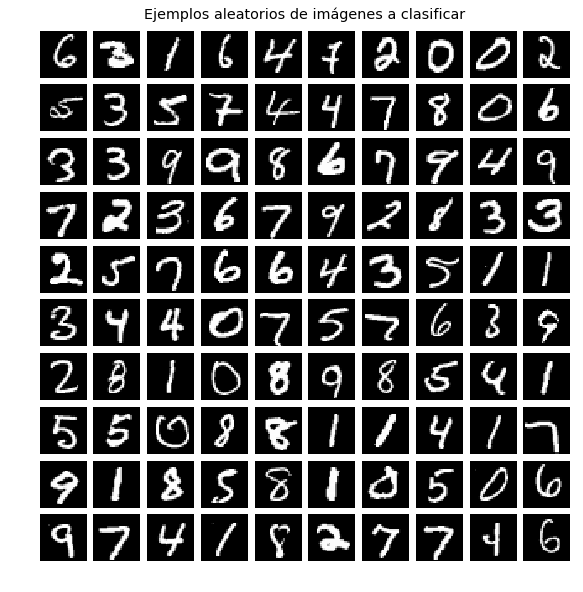

In [24]:
indices = np.arange(mnist.train.images.shape[0])
np.random.shuffle(indices)
ind = indices[0:100].reshape(10,10)

imagen = np.ones((10 * 28 + 4*11, 10 * 28 + 4*11))
for i in range(10):
    for j in range(10):
        imagen[4 + i * 32: 32 + i * 32, 4 + j * 32: 32 + j * 32] = \
        mnist.train.images[ind[i, j], :].reshape(28,28)
        
plt.imshow(imagen, cmap=plt.gray())
plt.axis('off')
plt.title(u"Ejemplos aleatorios de imágenes a clasificar")
plt.show()

## 2. Construcción de la red neuronal

Para hacer una red neuronal lo más genérica posible y que podamos reutilizar en otros proyectos, vamos a establecer los parámetros base independientemente de la inicialización de la red, independientemente de la forma en que construimos la red. 

Comencemos por establecer una función genérica que nos forme una red neuronal con dos capas convolucionales y una capa oculta densa posterior. 

In [0]:
def cnn_mnist(x, pesos, sesgos, dropout):
    """
    Genera una red neuronal de dos capas para usar en TensorFlow
    
    Parámetros
    ----------
    pesos: un diccionario con cuatro etiquetas: 'c1', 'c2', w1' y 'wo'
           en donde cada una es una tf.Variable conteniendo una 
           matriz con los pesos tanto de los filtros convolucionales 'c1' y'c2'
           como de las capas densas 'w1' y 'wo'
                  
    sesgos: un diccionario con cuatro etiquetas: 'b1', 'b2, 'b3' y 'bo'
            en donde cada una es una tf.Variable conteniendo un
            vector de dimensión [numero_de_neuronas_capa]
            
    dropout: Un flotante 0 <= dropout <= 1 con el porcentaje de dropout 
             en la capa densa oculta
                   
    Devuelve
    --------
    Un ops de tensorflow que calcula la salida de una red neuronal
    con dos capas convolucionales, una capa oculta, y activaciones RELU.
    
    """
    # Ajusta el vector de entrada de (-1, 784) que son los ejemplos que entran
    # a la red para reconocimiento y/o aprendizaje, a un tensor de dimensión
    # [-1, 28, 28, 1] (el último 1 implica que es una imagen BW, o una sola capa)
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
       
    # Primera capa convolucional con activación ReLU y max_pool de 2X2
    capa_1 = tf.nn.conv2d(x, pesos['c1'], strides=[1, 1, 1, 1], padding='SAME')
    capa_1 = tf.nn.bias_add(capa_1, sesgos['b1'])
    capa_1 = tf.nn.relu(capa_1)
    capa_1m = tf.nn.max_pool(capa_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Segunda capa convolucional con activación ReLU
    capa_2 = tf.nn.conv2d(capa_1m, pesos['c2'], strides=[1, 1, 1, 1], padding='SAME')
    capa_2 = tf.nn.bias_add(capa_2, sesgos['b2'])
    capa_2 = tf.nn.relu(capa_2)
    capa_2m = tf.nn.max_pool(capa_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Desenrollamos las imágenes para poder aplicar capas densas
    capa_2desen = tf.reshape(capa_2m, [-1, pesos['w1'].get_shape().as_list()[0]])
    
    # Capa oculta densa con activación ReLU
    capa_3 = tf.matmul(capa_2desen, pesos['w1'])
    capa_3 = tf.add(capa_3, sesgos['b3'])
    capa_3 = tf.nn.relu(capa_3)
    
    # Se le agrega Dropout por la generalización
    capa_3 = tf.nn.dropout(capa_3, rate= 1 - dropout)

    # Capa de salida con activación lineal
    # En Tensorflow la salida es siempre lineal, y luego se especifica
    # la función de salida a la hora de calcularla como vamos a ver 
    # más adelante
    capa_salida = tf.matmul(capa_3, pesos['wo']) 
    capa_salida = tf.add(capa_salida, sesgos['bo'])
    return capa_salida

Y ahora necesitamos poder generar los datos de entrada a la red neuronal de
alguna manera posible. Afortunadamente sabemos exactamente que necesitaos, así
que vamos a hacer una función que nos genere las variables de peso y sesgo.

Por el momento, y muy a la brava, solo vamos a generarlas con números aletorios con una 
distribución $\mathcal{N}(0, 1)$.

In [0]:
def inicializa_pesos(filtro1, filtro2, n1, n2, n3):
    """
    Genera un diccionario con pesos  
    para ser utilizado en la función red_neuronal_dos_capas_ocultas
    
    Parámetros
    ----------
    filtro1: (x, y) tupla con el tamaño del primer filtro convolucional

    filtro2: (x, y) tupla con el tamaño del segundo filtro convolucional

    n1: Número de imágenes generadas con el primer filtro
    
    n2: Número de imagenes generadas con el segundo filtro
    
    n3: Número de neuronas en la capa oculta

    Asumimos que es una red para MNIST, por lo que la entrada son imágenes de 28 x 28 x 1 (BW)
    y que tenemos 10 valores de salida diferentes
    
    Como hacemos maxpool de 2x2, las imagenes despues de la primer capa convolucional seran de 
    14 x 14, y las imágenes que salgan de la segunda capa convolucional serán de 7 x 7
    
    Devuelve
    --------
    Dos diccionarios, uno con los pesos por capa y otro con los sesgos por capa
    
    """
    pesos = {
        'c1': tf.Variable(tf.random_normal([filtro1[0], filtro1[1], 1, n1])),
        'c2': tf.Variable(tf.random_normal([filtro2[0], filtro2[1], n1, n2])),
        'w1': tf.Variable(tf.random_normal([7 * 7 * n2, n3])),
        'wo': tf.Variable(tf.random_normal([n3, 10]))
    }
    
    sesgos = {
        'b1': tf.Variable(tf.random_normal([n1])),
        'b2': tf.Variable(tf.random_normal([n2])),
        'b3': tf.Variable(tf.random_normal([n3])),
        'bo': tf.Variable(tf.random_normal([10]))
    }
    
    return pesos, sesgos

Ahora necesitamos establecer los parámetros de la topología de la red neuronal. 
Tomemos en cuenta que estos prámetros los podríamos haber establecido desde
la primer celda, si el fin es estar variando los parámetros para escoger los que 
ofrezcan mejor desempeño.

In [0]:
num_entradas = 784  #  Lo sabemos por la inspección que hicimos a mnist
num_salidas = 10    # Ídem

# Aqui es donde podemos jugar
filtro1 = (5, 5)
filtro2 = (5, 5)
n1 = 32
n2 = 64
n3 = 1024

¡A construir la red! Para esto vamos a necesitar crear las entradas
con un placeholder, y crear nuestra topología de red neuronal.

Observa que la dimensión de x será [None, num_entradas], lo que significa que 
la cantidad de renglones es desconocida (o variable).

In [0]:
# La entrada a la red neuronal
x = tf.placeholder("float", [None, num_entradas])

# Los pesos y los sesgos
w, b = inicializa_pesos(filtro1, filtro2, n1, n2, n3) 

# El valor de dropout que puede variar en el tiempo
dp = tf.placeholder(tf.float32)

# Crea la red neuronal
estimado = cnn_mnist(x, w, b, dp)

Parecería que ya está todo listo. Sin ambargo falta algo muy importante: No hemos explicado
ni cual es el criterio de error (loss) que vamos a utilizar, ni cual va a ser el método de
optimización (aprendizaje) que hemos decidido aplicar.

Primero definamos el costo que queremos minimizar, y ese costo va a estar en función de lo
estimado con lo real, por lo que necesitamos otra entrada de datos para los datos de salida.
Sin ningun lugar a dudas, el costo que mejor describe este problema es el de *softmax*



In [0]:
#  Creamos la variable de datos de salida conocidos
y = tf.placeholder("float", [None, num_salidas])

#  Definimos la función de costo
costo = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=estimado, labels=y))

Y ahora definimos que función de aprendizaje vamos a utilizar. Existen muchas funciones
de aprendizaje en tensorflow, las cuales se pueden consultar en `tf.train.`. Entre las
existentes podemos ver algunas conocidas del curso como descenso de gradiente simple,
momento, rprop, rmsprop entre otras. Casi todas las funciones de optimización (aprendizaje)
acaban su nombre con `Optimize`.

En este caso vamos a usar un método comocido como el *algoritmo de Adam* el cual 
se puede consultar [aqui](http://arxiv.org/pdf/1412.6980.pdf). El metodo utiliza dos calculos
de momentos diferentes, y por lo visto genera resultados muy interesantes desde el punto 
de vista práctico.

¿Cual es el mejor método? Pues esto es en función de tu problema y de la cantidad de datos que tengas.
Lo mejor es practicar con varios métodos para entender sus ventajas y desventajas.

En todo caso el método de optimización requiere que se le inicialice con una tasa de aprendizaje.

In [0]:
alfa = 0.001
optimizador = tf.train.AdamOptimizer(learning_rate=alfa)
paso_entrenamiento = optimizador.minimize(costo)

## 3. Ejecutar la sesión usando mini-batches

Ahora, ya que la red neuronal está lista vamos a ejecutar la red utilizando el algoritmo de
Adam pero en forma de mini-batches. 

Con el fin de tener control sobre el problema, vamos a establecer un número máximo de epoch (ciclos de aprendizaje), el tamaño de los mini-batches, y cada cuandos epoch 
quisieramos ver como está evolucionando la red neuronal.

Como entrenar una red neuronal no tiene sentido, si no es porque la queremos usar para reconocer,
no tendría sentido entrenarla y luego perderla y tener que reentrenar en cada ocasión. Recuerda que cuando
se cierra la sesión se borra todo lo que se tenía en memoria. 

Para esto vamos a usar una ops especial llamada `Saver`, que permite guardar en un archivo la red neuronal y 
después utilizarla en otra sesión (en otro script, computadora, ....).

En colab esto solo se hace si uno le da permiso de utilizar el Drive para guardar y leer.



In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Y ahora ya podemos guardar lo que vayamos generando (y usarlo en otro lado)

In [0]:
archivo_modelo = "/content/gdrive/My Drive/modelo_cnn_simple"
saver = tf.train.Saver()

Como todo se ejecuta dentro de una sesión, no es posible hacerlo por partes (si usamos el 
`with` que debería ser la única forma en la que iniciaramos una sesión). Por lo tanto procuraré dejar comentado el código.

In [44]:
numero_epochs = 5
tamano_minibatch = 100
display_step = 1
dropout = 0.5

# Muy importante la primera vez que se ejecuta inicializar todas las variables
init = tf.global_variables_initializer()

# La manera correcta de iniciar una sesión y realizar calculos
with tf.Session() as sess:
    sess.run(init)

    # Ciclos de entrenamiento
    for epoch in range(numero_epochs):

        #  Inicializa el costo promedio de todos los minibatches en 0
        avg_cost = 0.
        
        #  Calcula el número de minibatches que se pueden usar 
        total_batch = int(mnist.train.num_examples/tamano_minibatch)

        #  Por cada minibatch
        for i in range(total_batch):
            
            #  Utiliza un generador incluido en mnist que obtiene 
            #  tamano_minibatch ejemplos selecionados aleatoriamente del total
            batch_x, batch_y = mnist.train.next_batch(tamano_minibatch)
            
            #  Ejecuta la ops del paso_entrenamiento para aprender 
            #  y la del costo, con el fin de mostrar el aprendizaje
            _, c = sess.run(
                [paso_entrenamiento, costo], 
                feed_dict={x: batch_x, y: batch_y, dp: dropout}
            )
            
            #  Calcula el costo del minibatch y lo agrega al costo total
            avg_cost += c / total_batch
        
        # Muestra los resultados
        if epoch % display_step == 0:
            print (("Epoch: " + str(epoch)).ljust(20)
                   + ("Costo: " + str(avg_cost)))
    
        #  Guarda la sesión en el archivo rnn2.cptk
        saver.save(sess, archivo_modelo, global_step=i)
    
    print("Se acabaron los epochs, saliendo de la sesión de tensorflow.")

Epoch: 0            Costo: 8822.18266424005
Epoch: 1            Costo: 895.9124943265052
Epoch: 2            Costo: 444.20903526306193
Epoch: 3            Costo: 279.9853063219245
Epoch: 4            Costo: 192.85359339107174
Se acabaron los epochs, saliendo de la sesión de tensorflow.


Ahora vamos a revisar que tan bien realizó el aprendizaje cuando se aplica la red adatos que
no se usaron para entrenamiento. Para esto vamos a utilizar dos ops extas: una 
para definir la operaración de datos bien estimados o mal estimados, y otra para
calcular el promedio de datos bien estimados. Para calcular los datos bien estimados vamos a utilizar `tf.cast` que permite ajustar los tipos
al tipo tensor. 

In [0]:
prediction_correcta = tf.equal(
    tf.argmax(estimado, 1), 
    tf.argmax(y, 1)
)

precision = tf.reduce_mean(tf.cast(prediction_correcta, "float"))

Ahora si, vamos a abrir una nueva sesión, vamos a restaurar los valores de la sesión anterior,
y vamos a ejecutar el grafo con el fin de evaluar la ops precision, pero ahora con el
diccionario de alimentación con los datos de prueba.

In [52]:
archivo_modelo = "/content/gdrive/My Drive/simple-cnn/modelo_cnn_simple-549"
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, archivo_modelo)
    porcentaje_acierto = sess.run(
        precision, 
        feed_dict={
            x: mnist.test.images,
            y: mnist.test.labels,
            dp: dropout
        }
    )
    print("Precisión: {}".format(porcentaje_acierto))

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/simple-cnn/modelo_cnn_simple-549
Precisión: 0.914900004863739


## 4. Algunas preguntas para reforzar la comprensión de la libreta

1. ¿Cuanto tiempo toma en realizar un epoch en colab usando TPU? ¿Y usando GPU o CPU?

2. Realiza solamente 5 epoch cada vez y prueba con el conjunto de test para comprobar como 
   mejora el reconocimiento. Reinicia el aprendizaje desde donde te quedaste (recuperando la sesión) al menos 3 veces más.

4. ¿Que pasa si cambias los tamaños de los filtros o el número de imágenes generadas?

5. ¿Que pasa si cambias el tamaño de los minibatches?

6. ¿Qué pasa si disminuyes el `dropout` a 0.25? ¿Qué pasa si aumentas el `dropout` a 0.75?

**Para contestar las preguntas, agrega cuantas celdas con comentarios y con códgo sean necesarias.** Aprovecha que las libretas de *Jupyter* te permite hacerte una especie de tutorial personalizado.